<a href="https://colab.research.google.com/github/HUSILEBAI/GEOG-5410/blob/main/GEOG_5410_Climate_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAO Analysis

This is the practise code for climate mode analysis. Start with connecting your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Sea Level Pressure (SLP) data
* Now, let's download the data using <button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">!curl -O -C</button> command. Here, we use [NCEP/DOE Reanalysis II](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html).

* Note that you only need to run this section once. And you can turn it off after you have your data downloaded.

In [ ]:
# !curl -O -C - https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/Monthlies/surface/mslp.mon.mean.nc

In [ ]:
!pip install cartopy eofs


In [ ]:
import glob
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Now use [xarray.open_dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) to read monthly mean sea surface pressure dataset.

* When you only need to read single file, do <br>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">xarray.open_dataset("file_name.nc")</button>

* When you need to read multiple files, do <br>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">xfile = sorted(glob.glob(file_name))</button> <br>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">mslp_dat = xr.open_dataset(file[0])</button>

In [ ]:
file_name = f"mslp.mon.mean.nc"
mslp_dat = xr.open_dataset(file_name)
mslp_dat


In [ ]:
# Reverse the latitude dimension
mslp_dat_reversed_lat = mslp_dat.isel(lat=slice(None, None, -1))
mslp_dat_reversed_lat

In [ ]:

# Read the data
lat = mslp_dat_reversed_lat.lat
lon = mslp_dat_reversed_lat.lon
mslp = mslp_dat_reversed_lat.mslp
print(f"Shape of latitude data is {lat.shape}")
print(f"Shape of longitude data is {lon.shape}")
print(f"Shape of mean sea surface pressure data is {mslp.shape}\n")
# print(f"latitude is {lat}")

Shape of latitude data is (73,)
Shape of longitude data is (144,)
Shape of mean sea surface pressure data is (542, 73, 144)



### NAO calculation
Here we use [Hurrell North Atlantic Oscillation (NAO) Index (PC-based)](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based) to compute the NAO.

<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">DJF mean</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lat_lim = [20 80]</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lon_lim = [-90 40]</button>


In [ ]:
# extract DJF mslp
mslp_DJF = mslp.where(mslp['time.season']=='DJF', drop=True)
print(f"Shape of mean sea surface pressure data in DJF is {mslp_DJF.shape}")

Shape of mean sea surface pressure data in DJF is (137, 73, 144)


In [ ]:
mslp_DJF_mean = mslp_DJF.mean('time')

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
cb = ax.contourf(lon, lat, mslp_DJF_mean, levels = 30,transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
# Add colorbar
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Mean Sea Level Pressure (hPa)')

plt.show()

In [ ]:
import cartopy.util as cutil
cdata, clon, clat = cutil.add_cyclic(mslp_DJF_mean, lon, lat)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30,transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
# Add colorbar
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Mean Sea Level Pressure (hPa)')
plt.show()

In [ ]:
# slice the mslp
lat_slice = slice(20, 80) # if slice(20, 80, -1) -1 is to reverse the latitude dimension

# Define the longitude slicing ranges
lon_slice1 = slice(270, 360)  # Slicing from 270°E to 360°E
lon_slice2 = slice(0, 40)  # Slicing from 0°E to 40°E

# Slice the data along the longitude dimension for each range
mslp_DJF_subset1 = mslp_DJF.sel(lat=lat_slice, lon=lon_slice1)
mslp_DJF_subset2 = mslp_DJF.sel(lat=lat_slice, lon=lon_slice2)

# Concatenate the subsets along the longitude dimension
mslp_DJF_subset = xr.concat([mslp_DJF_subset1, mslp_DJF_subset2], dim='lon')

print(f"Shape of subset of mean sea surface pressure data in DJF is {mslp_DJF_subset.shape}")

Shape of subset of mean sea surface pressure data in DJF is (137, 25, 53)


### EOF analysis

You might need to install eofs package in your colab env. Please run this <button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">!pip install eofs</button>  and install eof function first.

In [ ]:
from eofs.xarray import Eof

In [ ]:
# Calculate the anomaly of mslp_DJF_subset
mslp_DJF_anomaly = mslp_DJF_subset - mslp_DJF_subset.mean(dim='time')
print(f"Shape of anomaly of the DJF mean sea surface pressure data is {mslp_DJF_anomaly.shape}")

Shape of anomaly of the DJF mean sea surface pressure data is (137, 25, 53)


In [ ]:
# Create an EOF solver
solver = Eof(mslp_DJF_anomaly.transpose('time', 'lat', 'lon'))

In [ ]:
# Retrieve the leading EOF (EOF 1)
eof1 = solver.eofsAsCorrelation(neofs=1)
# Retrieve the PC time series of the leading EOF
pc1 = solver.pcs(npcs=1, pcscaling=1)
# Normalize the NAO index
nao_index_normalized = (pc1.values[:, 0] - np.mean(pc1.values[:, 0])) / np.std(pc1.values[:, 0])

# Print the shape of EOF1 and PC1
print("Shape of EOF 1:", eof1.shape)
print("Shape of PC 1:", pc1.shape)
print("Shape of NAO index:", nao_index_normalized.shape)


Shape of EOF 1: (1, 25, 53)
Shape of PC 1: (137, 1)
Shape of NAO index: (137,)


In [ ]:
# Plot the leading EOF (EOF 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot the EOF
im = axes[0].contourf(eof1[0, :, :])
fig.colorbar(im, ax=axes[0], label='EOF amplitude')
axes[0].set_title('Leading EOF (EOF 1)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xticks(range(0, eof1.shape[2] + 1, 10))
axes[0].set_yticks(range(0, eof1.shape[1] + 1, 10))
axes[0].grid(True)

# Plot the NAO index time series
axes[1].plot(pc1.time, nao_index_normalized)
axes[1].set_title('North Atlantic Oscillation (NAO) Index')
axes[1].set_xlabel('year')
axes[1].set_ylabel('Normalized Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the Pearson correlation coefficient using NumPy and xarray
corr_coef = xr.corr(mslp_DJF, xr.DataArray(nao_index_normalized, dims='time'), dim='time')

In [ ]:
cdata, clon, clat = cutil.add_cyclic(corr_coef, lon, lat)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Correlation Map (Plate Carree Projection)')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=90))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Correlation Map (Orthographic Projection)')
plt.show()



# NPO anaylsis
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">January mean</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lat_lim = [20 90]</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lon_lim = [120 240]</button>

In [ ]:
# extract January mslp
mslp_jan= mslp.where(mslp['time.month']==1, drop=True)
print(f"Shape of mean sea level pressure data in January is {mslp_jan.shape}")
# subset data to NPO domain
lat_lim = slice(20,90)
lon_lim = slice(120,240)
mslp_jan_subset = mslp_jan.sel(lat=lat_lim, lon=lon_lim)
print(f"Shape of subset mean sea level pressure data in January is {mslp_jan_subset.shape}")

Shape of mean sea level pressure data in January is (46, 73, 144)
Shape of subset mean sea level pressure data in January is (46, 29, 49)


In [ ]:
# Calculate the anomaly of mslp_Jan_subset
mslp_jan_anomaly = mslp_jan_subset - mslp_jan_subset.mean(dim='time')
print(f"Shape of anomaly of the Jan mean sea surface pressure data is {mslp_jan_anomaly.shape}")
# Create an EOF solver
solver = Eof(mslp_jan_anomaly.transpose('time', 'lat', 'lon'))
# Retrieve the leading EOF (EOF 1)
eof1 = solver.eofsAsCorrelation(neofs=1)
# Retrieve the PC time series of the leading EOF
pc1 = solver.pcs(npcs=1, pcscaling=1)
# Normalize the NAO index
npo_index_normalized = (pc1.values[:, 0] - np.mean(pc1.values[:, 0])) / np.std(pc1.values[:, 0])

# Print the shape of EOF1 and PC1
print("Shape of EOF 1:", eof1.shape)
print("Shape of PC 1:", pc1.shape)
print("Shape of NAO index:", nao_index_normalized.shape)

# Plot the leading EOF (EOF 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# Plot the EOF
im = axes[0].contourf(eof1[0, :, :])
fig.colorbar(im, ax=axes[0], label='EOF amplitude')
axes[0].set_title('Leading EOF (EOF 1)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xticks(range(0, eof1.shape[2] + 1, 10))
axes[0].set_yticks(range(0, eof1.shape[1] + 1, 10))
axes[0].grid(True)

# Plot the NAO index time series
axes[1].plot(pc1.time, npo_index_normalized)
axes[1].set_title('North Pacific Oscillation (NAO) Index')
axes[1].set_xlabel('year')
axes[1].set_ylabel('Normalized Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the Pearson correlation coefficient using NumPy and xarray
corr_coef = xr.corr(mslp_jan, xr.DataArray(npo_index_normalized, dims='time'), dim='time')
cdata, clon, clat = cutil.add_cyclic(corr_coef, lon, lat)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=ccrs.Orthographic(central_longitude=180, central_latitude=90))
ax.set_global()
cb = ax.contourf(clon, clat, cdata, levels = 30, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Correlation Map (Orthographic Projection)')
plt.show()

# El ñino 3.4 index

Here, we'll use [Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)](https://www.metoffice.gov.uk/hadobs/hadisst/)

In [ ]:
!curl -O -C - https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz
# Extract the data
!gunzip HadISST_sst.nc.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  228M  100  228M    0     0  62.3M      0  0:00:03  0:00:03 --:--:-- 62.3M


In [ ]:
sst_file = f"HadISST_sst.nc"
sst_dat = xr.open_dataset(sst_file)
sst_dat

In [ ]:
# Reverse the latitude dimension
sst_dat_reversed_lat = sst_dat.isel(latitude=slice(None, None, -1))
sst = sst_dat_reversed_lat.sst
print(f"Shape of the SST is {sst}")

Shape of the SST is <xarray.DataArray 'sst' (time: 1849, latitude: 180, longitude: 360)>
[119815200 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-0...
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean


### Compute the index based on the NCAR climate data guide, you can find it here [Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI)](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lat_lim = [-5, 5]</button>
<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lon_lim = [-170, -120]</button>

In [ ]:
# Slice the SST data
lat_lim = slice(-5, 5)
lon_lim = slice(-170, -120)
sst_subset = sst.sel(latitude=lat_lim, longitude=lon_lim)
print(f"Shape of subset of sea surface temperature data is {sst_subset.shape}")

Shape of subset of sea surface temperature data is (1849, 10, 50)


In [ ]:
# Calculate the mean SST over the Niño 3.4 domain
sst_mean = sst_subset.mean(dim={'latitude', 'longitude'})
print(f"The mean SST over the ñino 3.4 domain is {sst_mean}")

# Calculate the standard deviation of sst_subset
sst_std = sst_subset.std(dim=('latitude', 'longitude'))

# Calculate the z-score
ñino34 = (sst_mean - sst_mean.mean()) / sst_std
print(f"Ñino 3.4 index is {ñino34}")

The mean SST over the ñino 3.4 domain is <xarray.DataArray 'sst' (time: 1849)>
array([25.53982 , 25.541965, 26.419275, ..., 28.633043, 28.368902,
       28.260172], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-01-...
Ñino 3.4 index is <xarray.DataArray 'sst' (time: 1849)>
array([-1.1359055, -1.8942174, -0.9131663, ...,  1.6145716,  1.5041076,
        1.4923558], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-01-...


In [ ]:
ñino34_jul = ñino34[0::12]

# Plot the Niño 3.4 index for July
ñino34_jul.plot()

# Add labels and title
plt.xlabel('year')
plt.ylabel('Z-Score of Niño 3.4 Index')
plt.title('Niño 3.4 Index for July')

# Show the plot
plt.show()

In [ ]:
for i in range(6):
    subset = ñino34[i::12]  # Extract subset with interval of 12 starting from index i
    plt.plot(subset.time,subset, label=f'Month = {i+1}')

plt.xlabel('Time Step')
plt.ylabel('Values')
plt.title('Monthly ñino 3.4 index')
plt.legend()
plt.show()

In [ ]:
# sst_jul = sst.where(sst['time.month']==7,drop=True)
# sst_jul = sst_jul.where((sst_jul != -1000), np.nan)
# # corr = xr.corr(sst_jul, nino34_jul, dim='time', skipna=True)
# corr = xr.corr(sst_jul, xr.DataArray(ñino34_jul, dims='time'), dim='time')
# corr

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
# ax.set_global()
# cb = ax.contourf(sst.longitude, sst.latitude, corr, levels = 30, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# ax.coastlines()
# cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
# cbar.set_label('Correlation Map')
# plt.show()

# surface temperature

In [ ]:
!curl -O -C - https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/Monthlies/gaussian_grid/air.2m.mon.mean.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.2M  100 19.2M    0     0  13.4M      0  0:00:01  0:00:01 --:--:-- 13.4M


In [ ]:
file_name = f"air.2m.mon.mean.nc"
t2_dat = xr.open_dataset(file_name)
t2_dat = t2_dat.isel(lat=slice(None, None, -1))
t2_dat

<xarray.Dataset>
Dimensions:    (level: 1, lat: 94, lon: 192, time: 542, nbnds: 2)
Coordinates:
  * level      (level) float32 2.0
  * lat        (lat) float32 -88.54 -86.65 -84.75 -82.85 ... 84.75 86.65 88.54
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    air        (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

In [ ]:
lat = t2_dat.lat
lon = t2_dat.lon
air_dat = t2_dat.air
air_dat_subset = air_dat.where((air_dat['time.year'] >= 1980) & (air_dat['time.year'] <= 2023), drop=True)
air_mean = air_dat_subset.mean({'time','level'})
air_mean

<xarray.DataArray 'air' (lat: 94, lon: 192)>
array([[230.49625, 230.34691, 230.19702, ..., 230.94403, 230.79529,
        230.64584],
       [232.22351, 231.86382, 231.50763, ..., 233.32138, 232.9538 ,
        232.58746],
       [233.17401, 232.62833, 232.09613, ..., 234.89215, 234.30676,
        233.73418],
       ...,
       [258.00693, 258.12994, 258.23184, ..., 257.74567, 257.81906,
        257.91528],
       [257.84274, 257.9023 , 257.94476, ..., 257.7488 , 257.78058,
        257.81882],
       [257.62802, 257.7101 , 257.7006 , ..., 257.65894, 257.66742,
        257.6297 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.54 -86.65 -84.75 -82.85 ... 84.75 86.65 88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1

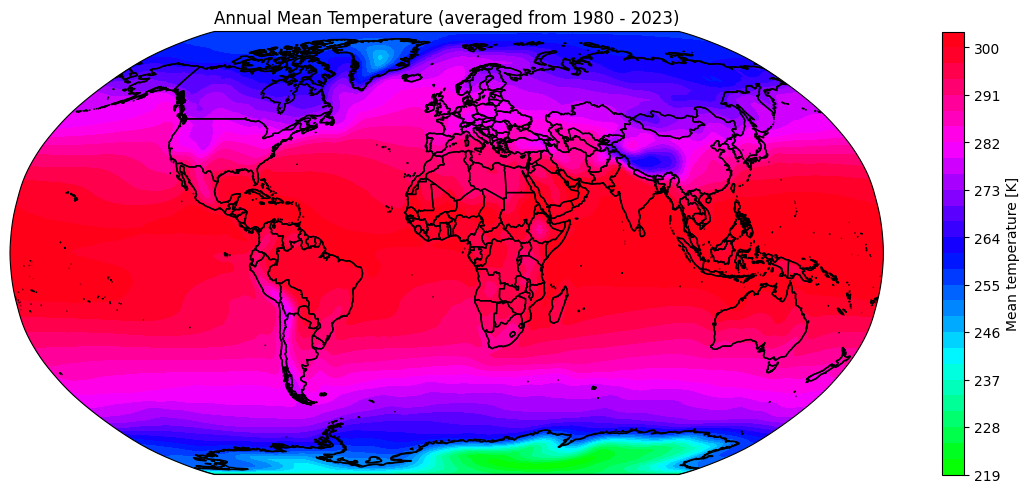

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.feature import NaturalEarthFeature

# Adding cyclic to the data and coordinates
cdata, clon, clat = cutil.add_cyclic(air_mean, lon, lat)
vmin=180
vmax=300
# Plotting
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
cb = ax.contourf(clon, clat, cdata,
                 levels=30,
                 vmin = vmin,
                 vmax = vmax,
                 transform=ccrs.PlateCarree(),
                 cmap='hsv')  # Assuming you want to plot the first level
cbar = plt.colorbar(cb, ax=ax, orientation='vertical')
cbar.set_label('Mean temperature [K]')
ax.coastlines()
ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none', edgecolor='black'))
plt.title('Annual Mean Temperature (averaged from 1980 - 2023)')
# Tight layout to adjust spacing
plt.tight_layout()
plt.show()


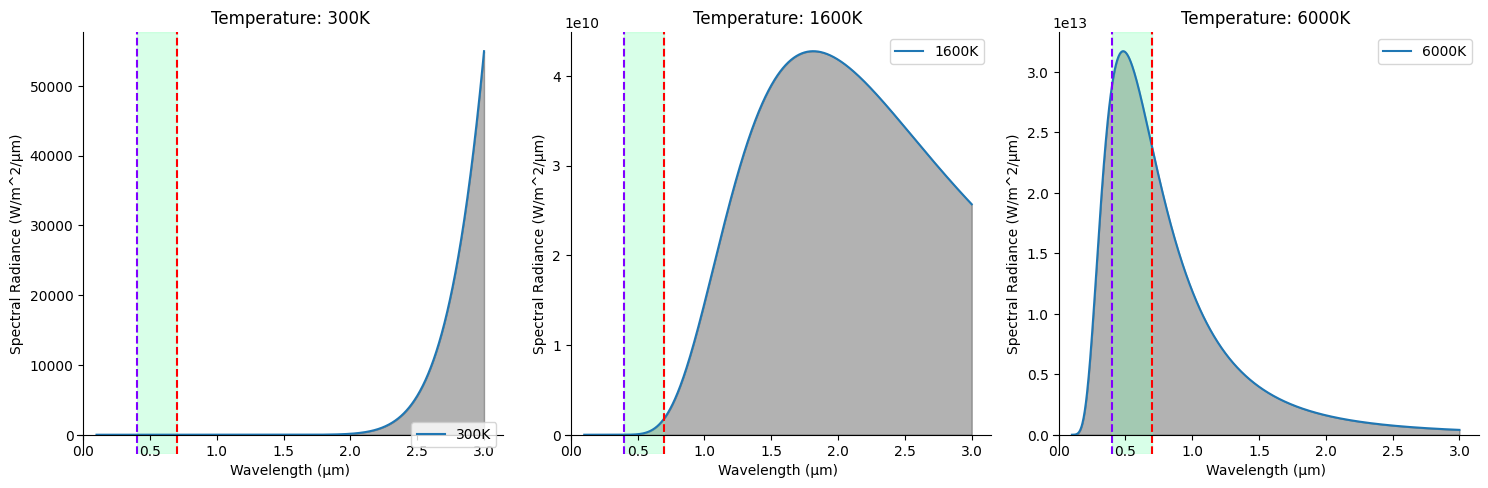

In [78]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'

# Define constants
h = 6.626e-34  # Planck's constant
c = 3.0e+8     # Speed of light
k = 1.38e-23   # Boltzmann constant

# Define function to calculate spectral radiance
def spectral_radiance(wavelength, temperature):
    return (2 * h * c**2) / (wavelength**5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1))

# Define wavelengths in micrometers (μm)
wavelengths = np.linspace(0.1, 3, 1000)  # Wavelengths from 0.1 μm to 3 μm

# Define temperatures
temperatures = [300, 1600, 6000]  # in Kelvin

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for each temperature
for i, temp in enumerate(temperatures):
    ax = axes[i]
    radiance = spectral_radiance(wavelengths * 1e-6, temp)  # Convert wavelengths to meters
    ax.plot(wavelengths, radiance, label=f"{temp}K")
    ax.fill_between(wavelengths, radiance, where=(radiance >= 0), color='black', alpha=0.3)  # Fill area under the radiance line
    ax.set_xlabel('Wavelength (μm)')  # Set xlabel in micrometers
    ax.set_ylabel('Spectral Radiance (W/m^2/μm)')
    ax.set_title(f'Temperature: {temp}K')
    ax.legend()
    # ax.set_xlim([0, 3])
    ax.tick_params(axis='x', colors='black')  # Set tick color to black
    ax.tick_params(axis='y', colors='black')  # Set tick color to black
    ax.spines['bottom'].set_color('black')  # Set bottom spine color to black
    ax.spines['top'].set_color('black')  # Set top spine color to black
    ax.spines['left'].set_color('black')  # Set left spine color to black
    ax.spines['right'].set_color('black')  # Set right spine color to black
    # Add rainbow-colored vertical lines
    rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, 2))
    for color, xpos in zip(rainbow_colors, [0.4, 0.7]):
        ax.axvline(x=xpos, color=color, linestyle='--')
    ax.axvspan(0.4, 0.7, color=plt.cm.rainbow(0.5), alpha=0.3)

    # Overlay x and y axes
    ax.spines['left'].set_position('zero')  # Set y-axis spine position to overlay
    ax.spines['bottom'].set_position('zero')  # Set x-axis spine position to overlay

    # Hide right and top spines
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.tight_layout()
plt.show()

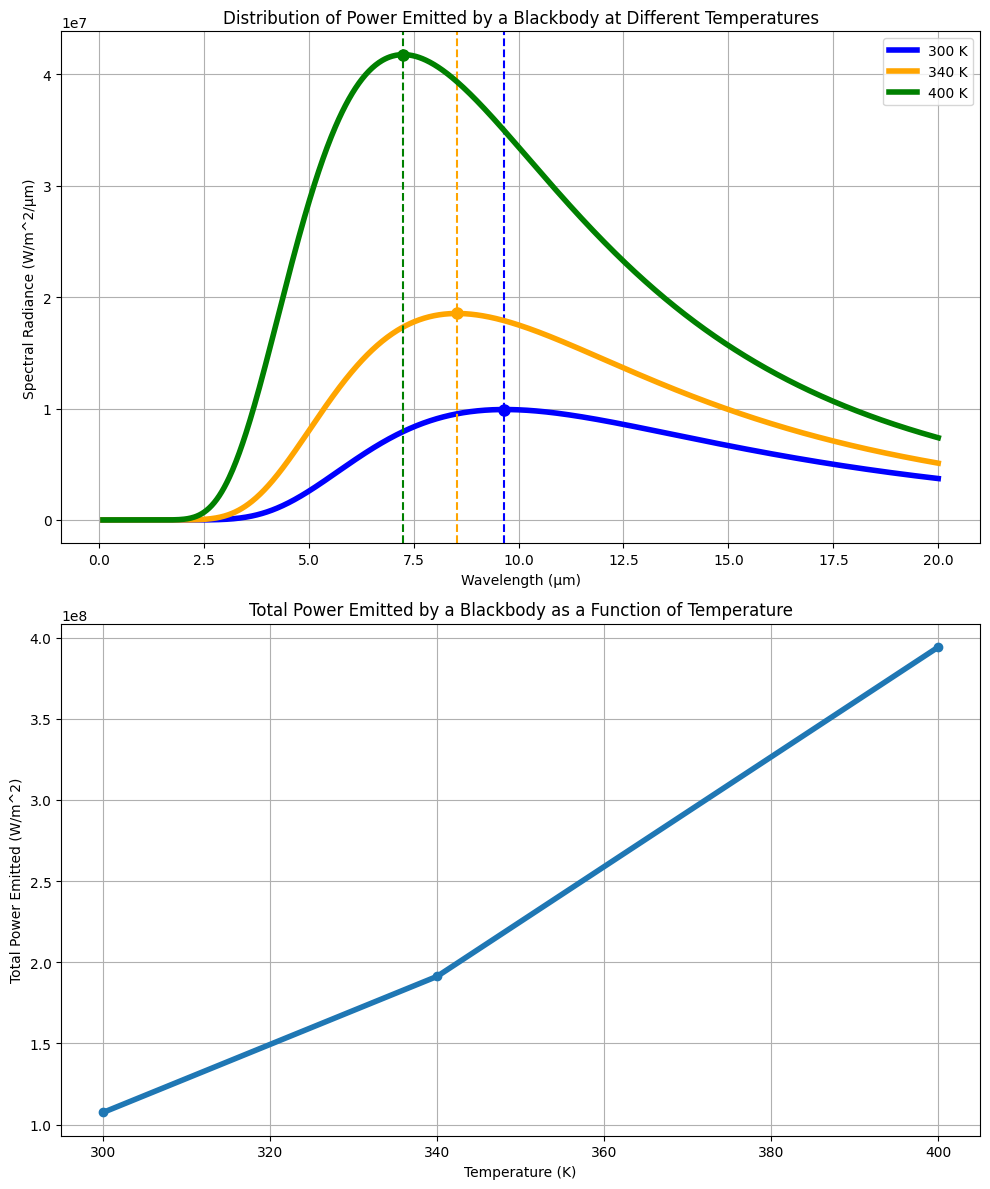

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 6.626e-34  # Planck's constant (J*s)
c = 3.0e+8     # Speed of light (m/s)
k = 1.38e-23   # Boltzmann constant (J/K)

# Function to calculate spectral radiance of a blackbody
def spectral_radiance(wavelength, temperature):
    wavelength_m = wavelength * 1e-6  # Convert wavelength to meters
    return (2 * h * c**2) / (wavelength_m**5 * (np.exp((h * c) / (wavelength_m * k * temperature)) - 1))

# Wavelengths in micrometers (μm)
wavelengths = np.linspace(0.1, 20, 1000)  # Wavelengths from 0.1 μm to 3 μm

# Temperatures in Kelvin
temperatures = [300, 340, 400]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot (a): Distribution of power emitted by a blackbody at different temperatures
colors = ['blue', 'orange', 'green']
for i, temp in enumerate(temperatures):
    radiance = spectral_radiance(wavelengths, temp)
    color = colors[i % len(colors)]  # Cycle through colors if more temperatures than colors
    axes[0].plot(wavelengths, radiance, label=f"{temp} K", color=color, linewidth=4)
    peak_wavelength = wavelengths[np.argmax(radiance)]  # Find wavelength at peak
    peak_radiance = np.max(radiance)  # Find radiance at peak
    axes[0].plot(peak_wavelength, peak_radiance, marker='o', markersize=8, color=color)  # Add dot marker at peak
    axes[0].axvline(x=peak_wavelength, linestyle='--', color=color)  # Add vertical dashed line at peak
axes[0].set_xlabel('Wavelength (μm)')
axes[0].set_ylabel('Spectral Radiance (W/m^2/μm)')
axes[0].set_title('Distribution of Power Emitted by a Blackbody at Different Temperatures')
axes[0].legend()
axes[0].grid(True)

# Plot (b): Total power emitted by a blackbody as a function of temperature
total_power = [np.trapz(spectral_radiance(wavelengths, temp), wavelengths) for temp in temperatures]
axes[1].plot(temperatures, total_power, marker='o', linestyle='-', linewidth=4)
axes[1].set_xlabel('Temperature (K)')
axes[1].set_ylabel('Total Power Emitted (W/m^2)')
axes[1].set_title('Total Power Emitted by a Blackbody as a Function of Temperature')
axes[1].grid(True)

plt.tight_layout()
plt.show()